## DIA 008: Bosques Aleatorios (Random Forest) para Clasificacion

Los Bosques Aleatorios (Random Forests) son un potente algoritmo de aprendizaje supervisado que se utiliza tanto para clasificación como para regresión. Este método combina múltiples árboles de decisión para crear un modelo más robusto y preciso.

Características clave de los Bosques Aleatorios:

- Ensemble Learning: Combina varios modelos débiles (árboles de decisión) para formar un modelo fuerte.
- Reducción del Sobreajuste: Al promediar múltiples árboles, se reduce la variabilidad y el sobreajuste presente en un único árbol de decisión.
- Importancia de las Características: Permite identificar qué variables tienen mayor impacto en las predicciones.
- Manejo de Datos Grandes: Eficiente en términos de tiempo y capaz de manejar grandes conjuntos de datos con múltiples características.
- Versatilidad: Funciona bien tanto con variables categóricas como numéricas sin necesidad de escalado. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
import joblib

# 1. Load the Dataset
df = pd.read_csv("titanic.csv")

In [5]:
# 2. Initial exploration
print("First rows of the dataset")
print(df.head())

print("\nGeneral information")
print(df.info())

print("\nNull values per column")
print(df.isnull().sum())

print("\nDescriptive statics")
print(df.describe())

First rows of the dataset
   PassengerId  Survived  Pclass  ...     Fare Cabin  Embarked
0            1         0       3  ...   7.2500   NaN         S
1            2         1       1  ...  71.2833   C85         C
2            3         1       3  ...   7.9250   NaN         S
3            4         1       1  ...  53.1000  C123         S
4            5         0       3  ...   8.0500   NaN         S

[5 rows x 12 columns]

General information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-n

In [6]:
# 3. Selection of relevant characteristics
# features = funciones
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
target = 'Survived'

df_selected = df[features + [target]]

In [8]:
# 4. Handling of null values
df_selected['Age'].fillna(df_selected['Age'].median(), inplace=True)
df_selected['Embarked'].fillna(df_selected['Embarked'].mode()[0], inplace=True)

print("\nNull values after imputation")
print(df_selected.isnull().sum())


Null values after imputation
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
Survived    0
dtype: int64


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_4012\2193549008.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_selected['Age'].fillna(df_selected['Age'].median(), inplace=True)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_4012\2193549008.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['Age'].fillna(df_selected['Age'].media

In [9]:
# 5. Conversion of categorical variables into numerical variables
df_selected['Sex'] = df_selected['Sex'].map({'male':0, 'female':1})
df_selected = pd.get_dummies(df_selected, columns=['Embarked'], drop_first=True)

print("\nFirst rows after preprocessing")
print(df_selected.head())


First rows after preprocessing
   Pclass  Sex   Age  SibSp  Parch     Fare  Survived  Embarked_Q  Embarked_S
0       3    0  22.0      1      0   7.2500         0       False        True
1       1    1  38.0      1      0  71.2833         1       False       False
2       3    1  26.0      0      0   7.9250         1       False        True
3       1    1  35.0      1      0  53.1000         1       False        True
4       3    0  35.0      0      0   8.0500         0       False        True


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_4012\1007239110.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['Sex'] = df_selected['Sex'].map({'male':0, 'female':1})


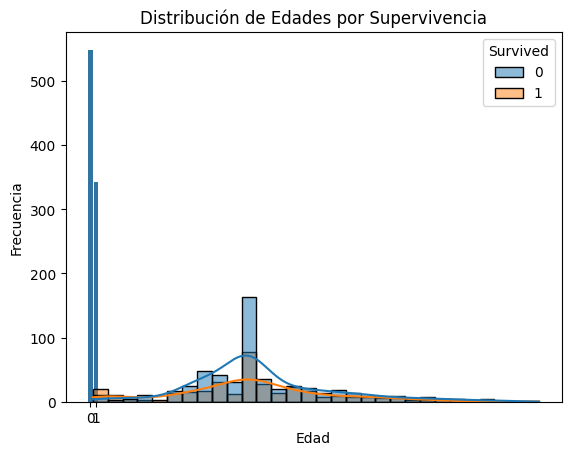

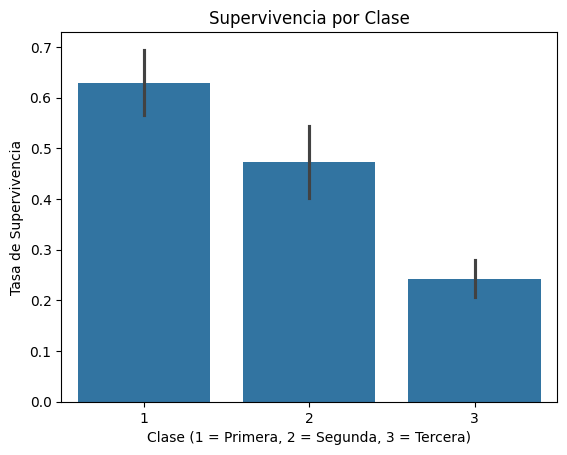

In [12]:
# 6. Data visualization
# Survivors distribution
sns.countplot(x='Survived', data=df_selected)
plt.title('Distribution of survivors')
plt.xlabel('Survived (0=No, 1=Si)')
plt.ylabel('Quantity')
plt.show

# Distribución de edades por supervivencia
sns.histplot(data=df_selected, x='Age', hue='Survived', kde=True, bins=30)
plt.title('Distribución de Edades por Supervivencia')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.show()

# Relación entre clase y supervivencia
sns.barplot(x='Pclass', y='Survived', data=df_selected)
plt.title('Supervivencia por Clase')
plt.xlabel('Clase (1 = Primera, 2 = Segunda, 3 = Tercera)')
plt.ylabel('Tasa de Supervivencia')
plt.show()

In [13]:
# 7. Preparación de los datos para el modelo
X = df_selected.drop('Survived', axis=1)
y = df_selected['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'\nTamaño del conjunto de entrenamiento: {X_train.shape[0]}')
print(f'Tamaño del conjunto de prueba: {X_test.shape[0]}')


Tamaño del conjunto de entrenamiento: 712
Tamaño del conjunto de prueba: 179


In [14]:
# 8. Entrenamiento del modelo de Bosque Aleatorio
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [15]:
# 9. Predicciones
y_pred = rf.predict(X_test)
y_pred_prob = rf.predict_proba(X_test)[:,1]

print("\nPredicciones en el conjunto de prueba:")
print(y_pred[:10])


Predicciones en el conjunto de prueba:
[0 0 0 1 0 1 1 0 1 1]



Precisión del modelo: 0.80


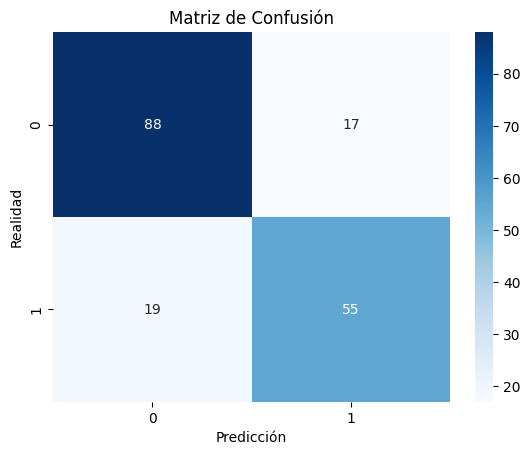


Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.82      0.84      0.83       105
           1       0.76      0.74      0.75        74

    accuracy                           0.80       179
   macro avg       0.79      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



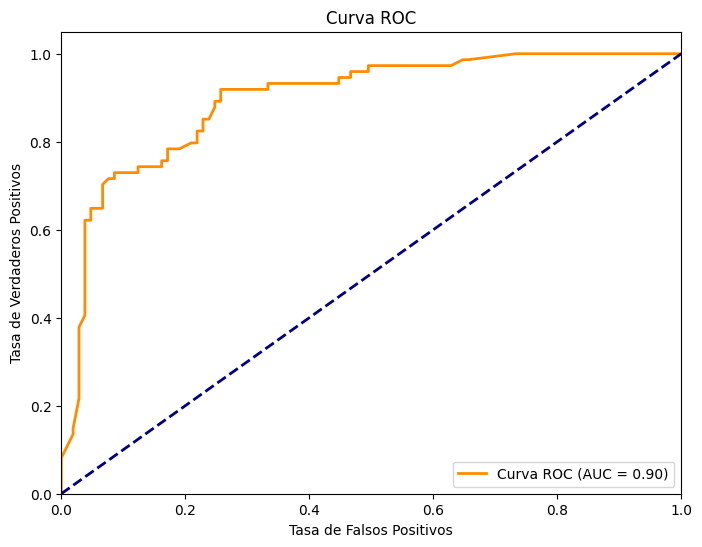

In [16]:
# 10. Evaluación del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'\nPrecisión del modelo: {accuracy:.2f}')

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.show()

# Reporte de clasificación
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

# Curva ROC y AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()


Importancia de las características:
      Feature  Importancia
5        Fare     0.273568
1         Sex     0.268369
2         Age     0.253454
0      Pclass     0.080003
3       SibSp     0.054522
4       Parch     0.037680
7  Embarked_S     0.022740
6  Embarked_Q     0.009663


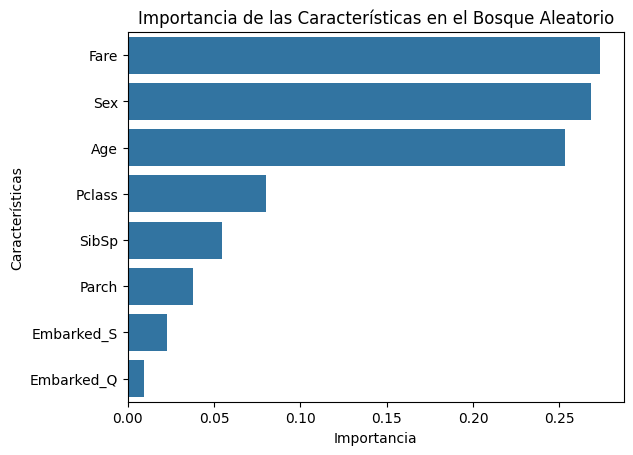

In [17]:
# 11. Interpretación de la Importancia de las Características
# Importancia de las características
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importancia': rf.feature_importances_
}).sort_values(by='Importancia', ascending=False)

print("\nImportancia de las características:")
print(feature_importances)

# Visualizar la importancia
sns.barplot(x='Importancia', y='Feature', data=feature_importances)
plt.title('Importancia de las Características en el Bosque Aleatorio')
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.show()

Fitting 5 folds for each of 216 candidates, totalling 1080 fits

Mejores parámetros: {'bootstrap': False, 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Mejor precisión en validación cruzada: 0.84

Precisión del modelo optimizado: 0.80


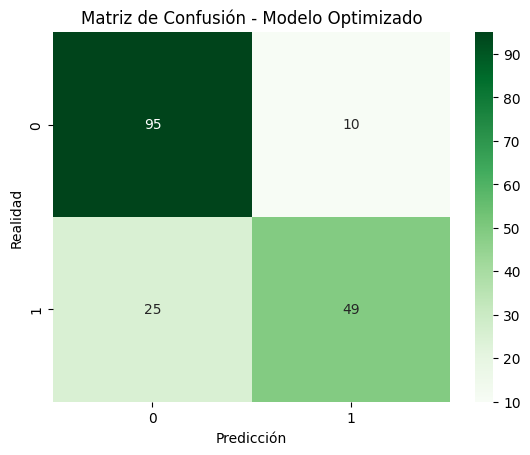


Reporte de Clasificación - Modelo Optimizado:
              precision    recall  f1-score   support

           0       0.79      0.90      0.84       105
           1       0.83      0.66      0.74        74

    accuracy                           0.80       179
   macro avg       0.81      0.78      0.79       179
weighted avg       0.81      0.80      0.80       179



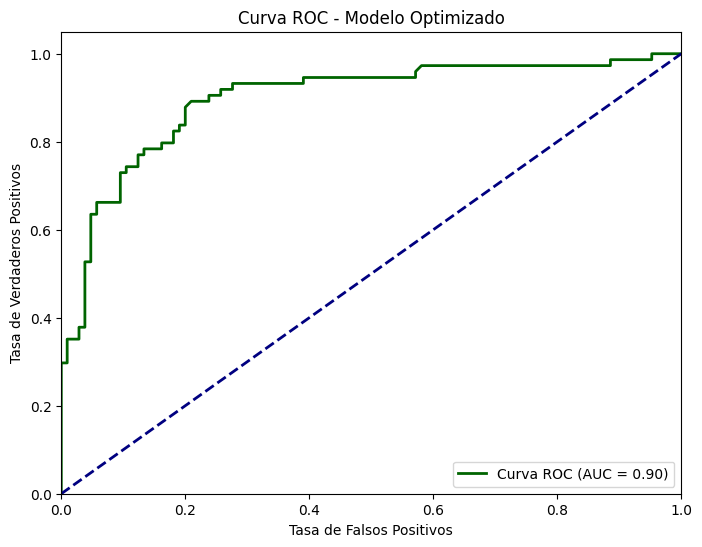

In [18]:
# 12. Optimización del Modelo
# Definir el rango de hiperparámetros
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 7, 9, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Instanciar el modelo
rf = RandomForestClassifier(random_state=42)

# Grid Search con validación cruzada de 5 folds
grid_search = GridSearchCV(
    estimator=rf, 
    param_grid=param_grid, 
    cv=5, 
    scoring='accuracy', 
    n_jobs=-1, 
    verbose=1
)
grid_search.fit(X_train, y_train)

# Mejor combinación de parámetros
print(f'\nMejores parámetros: {grid_search.best_params_}')
print(f'Mejor precisión en validación cruzada: {grid_search.best_score_:.2f}')

# Entrenar el modelo con los mejores parámetros
best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_test)
y_pred_prob_best = best_rf.predict_proba(X_test)[:,1]

# Evaluar el modelo optimizado
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f'\nPrecisión del modelo optimizado: {accuracy_best:.2f}')

# Matriz de confusión optimizada
cm_best = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Greens')
plt.title('Matriz de Confusión - Modelo Optimizado')
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.show()

# Reporte de clasificación optimizado
print("\nReporte de Clasificación - Modelo Optimizado:")
print(classification_report(y_test, y_pred_best))

# Curva ROC y AUC optimizada
fpr_best, tpr_best, thresholds_best = roc_curve(y_test, y_pred_prob_best)
roc_auc_best = auc(fpr_best, tpr_best)

plt.figure(figsize=(8,6))
plt.plot(fpr_best, tpr_best, color='darkgreen', lw=2, label=f'Curva ROC (AUC = {roc_auc_best:.2f})')
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC - Modelo Optimizado')
plt.legend(loc='lower right')
plt.show()